In [169]:
import numpy as np
import pandas as pd
import os
import pydicom
import matplotlib.pyplot as plt
import glob
from mask_functions import rle2mask, mask2rle
from pathlib import Path
import cv2
import pathlib
from sklearn.model_selection import train_test_split
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import VGG16
import seaborn as sns
import random
from sklearn import preprocessing
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import confusion_matrix
%matplotlib inline

## Data Pre-processing

In [108]:
df = pd.read_csv('Dataset_Phase1/train-rle.csv', header=0)
df

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...
...,...,...
11577,1.2.276.0.7230010.3.1.4.8323329.4461.151787518...,592067 6 1016 10 1012 14 1007 18 1004 20 1003...
11578,1.2.276.0.7230010.3.1.4.8323329.4461.151787518...,610576 3 1001 38 981 53 966 63 956 73 947 87 ...
11579,1.2.276.0.7230010.3.1.4.8323329.32730.15178751...,-1
11580,1.2.276.0.7230010.3.1.4.8323329.13252.15178752...,-1


In [86]:
# convert train dicom images to PNG
input_train_path = 'Dataset_Phase1/Train/'
output_train_path = 'Dataset_Phase1/Train_PNG/'

file_list = [f for f in os.listdir(input_train_path)]

for f in file_list:
    ds = pydicom.read_file(input_train_path + f)
    img = ds.pixel_array
    cv2.imwrite(output_train_path + f.replace('.dcm', '.png'), img)

In [87]:
# convert test dicom images to PNG
input_train_path = 'Dataset_Phase1/Test/'
output_train_path = 'Dataset_Phase1/Test_PNG/'

file_list = [f for f in os.listdir(input_train_path)]

for f in file_list:
    ds = pydicom.read_file(input_train_path + f)
    img = ds.pixel_array
    cv2.imwrite(output_train_path + f.replace('.dcm', '.png'), img)

In [94]:
# get the train images list
train_names = []
test_names = []
train_path = os.listdir('Dataset_Phase1/Train/')
test_path = os.listdir('Dataset_Phase1/Test/')

for file in train_path:
    file = os.path.splitext(file)[0]
    train_names.append(file)
    
for file in test_path:
    file = os.path.splitext(file)[0]
    test_names.append(file)   
    
print(len(train_names), len(test_names))

10712 1377


In [95]:
# training dataset
segmentation = 'Dataset_Phase1/train-rle.csv'
anns = pd.read_csv(segmentation)
anns.head()
        

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


In [96]:
anns.columns = ['ImageId', 'EncodedPixels']

In [97]:
pneumothorax_anns = anns[anns.EncodedPixels != ' -1'].ImageId.unique().tolist()
print(f'Positive samples: {len(pneumothorax_anns)}/{len(anns.ImageId.unique())} {100*len(pneumothorax_anns)/len(anns.ImageId.unique()):.2f}%')

Positive samples: 2379/10675 22.29%


In [123]:
pneumothorax = []
normal = []
for name in train_names:
    if(name in pneumothorax_anns):
        pneumothorax.append(name)
    else:
        normal.append(name)
        
print(pneumothorax)

['1.2.276.0.7230010.3.1.4.8323329.10005.1517875220.958951', '1.2.276.0.7230010.3.1.4.8323329.10011.1517875220.977487', '1.2.276.0.7230010.3.1.4.8323329.10012.1517875220.965942', '1.2.276.0.7230010.3.1.4.8323329.10016.1517875220.992175', '1.2.276.0.7230010.3.1.4.8323329.10025.1517875221.19235', '1.2.276.0.7230010.3.1.4.8323329.10026.1517875221.22915', '1.2.276.0.7230010.3.1.4.8323329.10031.1517875221.31204', '1.2.276.0.7230010.3.1.4.8323329.10032.1517875221.34651', '1.2.276.0.7230010.3.1.4.8323329.10034.1517875221.47394', '1.2.276.0.7230010.3.1.4.8323329.10037.1517875221.677730', '1.2.276.0.7230010.3.1.4.8323329.10042.1517875221.699011', '1.2.276.0.7230010.3.1.4.8323329.10046.1517875221.743999', '1.2.276.0.7230010.3.1.4.8323329.10047.1517875221.722653', '1.2.276.0.7230010.3.1.4.8323329.10050.1517875221.763035', '1.2.276.0.7230010.3.1.4.8323329.10057.1517875221.791666', '1.2.276.0.7230010.3.1.4.8323329.10060.1517875221.792744', '1.2.276.0.7230010.3.1.4.8323329.10064.1517875221.817093', '

In [130]:
path = 'Dataset_Phase1/Train_PNG/'
files =  os.listdir(path)
normal_destination = 'Dataset_Phase1/Train_PNG/Normal/'
pneumothorax_destination = 'Dataset_Phase1/Train_PNG/Pneumothorax/'

for f in files:
    file = os.path.splitext(f)[0]
    if file in normal:
        shutil.move(path+f, normal_destination+f)
    else:
        shutil.move(path+f, pneumothorax_destination+f)  

Error: Cannot move a directory 'Dataset_Phase1/Train_PNG/Pneumothorax' into itself 'Dataset_Phase1/Train_PNG/Pneumothorax/Pneumothorax'.

In [171]:
relative_path = 'Dataset_Phase1/Train_PNG/'
train_path = relative_path + 'Train'
valid_path = relative_path + 'Valid'
test_path = 'Dataset_Phase1/Test_PNG/'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)

Found 8035 images belonging to 2 classes.
Found 2677 images belonging to 2 classes.


In [136]:
# capture train data and labels into respective list
size = 256
train_images = []
train_labels = []

for directory_path in glob.glob('Dataset_Phase1/Train_PNG/Train/*'):
    label = directory_path.split('\\')[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, '*.png')):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (size, size))
        train_images.append(img)
        train_labels.append(label)
        
# convert list to array
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [139]:
# capture valid data and labels into respective list
valid_images = []
valid_labels = []

for directory_path in glob.glob('Dataset_Phase1/Train_PNG/Valid/*'):
    label = directory_path.split('\\')[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, '*.png')):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (size, size))
        valid_images.append(img)
        valid_labels.append(label)
        
# convert list to array
valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)

Normal
Pneumothorax


In [142]:
# encode labels from text to integers
le = preprocessing.LabelEncoder()
le.fit(valid_labels)
valid_labels_encoded = le.transform(valid_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [143]:
# split data into train and test dataset
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, valid_images, valid_labels_encoded

# normalize pixel values to between 0 and 1
x_train, x_test = x_train /255.0, x_test / 255.0

In [145]:
# load model without classifier/ fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(size,size, 3))

for layer in VGG_model.layers:
    layer.trainable = False

VGG_model.summary()

58889256/58889256 [==============================] - 8s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [172]:
# feature extractor
feature_extractor = VGG_model.predict(train_batches)
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
X_for_training = features

804/804 [==============================] - 618s 768ms/step


In [173]:
model = xgb.XGBClassifier()
model.fit(X_for_training, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [ ]:
X_test_feature = VGG_model.predict(valid_batches)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [176]:
prediction = model.predict(X_test_features)
prediction = le.inverse_transform(prediction)

ValueError: Feature shape mismatch, expected: 25088, got 32768

In [164]:
print('Accuracy = ', metrics.accuracy_score(valid_batches, prediction))

Accuracy =  0.8195741501680986


<AxesSubplot: >

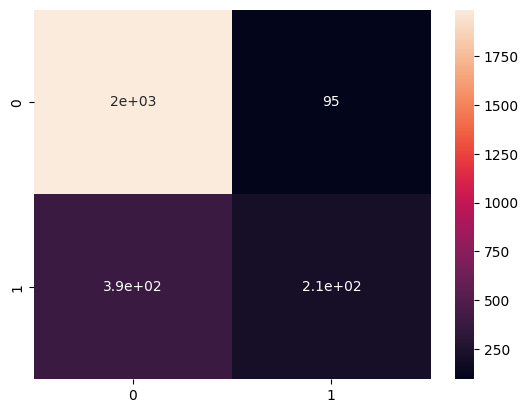

In [165]:
cm = confusion_matrix(valid_labels, prediction)
sns.heatmap(cm, annot=True)